Author: Alejandro Montanez-Barrera (j.montanez-barrera@fz-juelich.de). Posted: 18 Oct 2022.

# Solving the Portfolio Optimization problem using Qiskit

The Decision Optimization CPLEX modeling for python ([DOCPLEX](https://pypi.org/project/docplex/)) is a library that allows smooth prototyping for optimization problems. Here, we present the DOCPLEX optimization models into [QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization#Connection_to_Ising_models) representation. In general, problems in the form of [quadratic programming](https://en.wikipedia.org/wiki/Quadratic_programming) can be encoded using QUBOs. The three ingredints of an optimization model are the objective function, the equality constraints, and the inequality constraints. 

In this example, we show the solution of the portfolio optimization.

## 1. The Portfolio optimization problem 

Modern [Portfolio optimization](https://en.wikipedia.org/wiki/Portfolio_optimization) is a problem that involves finding the best set of assets that maximize the profit of those assets minimizing the risk of the investment. Usually, the risks are associated with changes in the market that makes the set of assets lose its value, and therefore investors lose part of their budget. 

This problem is known to be an NP-hard problem and its objective function is given by 

<div class="alert alert-block alert-success">
$$\max_{x} : \mu^{T} x-q x^{T} \Sigma x$$
</div>

Subject to: 
    $$\sum_{i=1}^{N} c_i x_i = B$$

where:
- $N$ represents the number of assets
- $x \in\{0,1\}^{N}$ denotes the vector of binary decision variables, which indicate which assets to pick ( $\left.x[i]=1\right)$ and which not to pick $(x[i]=0)$,
- $\mu \in R^{n}$ defines the expected returns for the assets,
- $\Sigma \in R^{n \times n}$ specifies the covariances between the assets,
- $q>0$ controls the risk aversion of the decision maker,
- $c_i$ is the cost of investing in the ith asset
- $B$ denotes the budget, i.e., the total investment..


In [ ]:
%pip install yfinance
%pip install cplex
%pip qiskit_optimization

In [176]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from docplex.mp.model import Model

colors = plt.cm.tab20(range(20))
label_size = 22
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 
plt.rcParams['axes.titlesize'] = label_size 

## S&P 500
The Standard and Poor's 500 ([S&P500](https://en.wikipedia.org/wiki/S%26P_500)) is a stock market index tracking the stock price performance of the 500 most valuable companies indexed in the US. We use [yfinance](https://pypi.org/project/yfinance/) to extract the stock index of 10 of these companies for this example. Here, you can find the whole set and the abreviation to extract more [S&P500 list](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).

We will work with:

- MSFT: Microsoft 
- AAPL: Apple Inc.
- GOOG: Alphabet
- PFE: Pfizer
- MRNA: Moderna
- JPM: JPMorgan Chase
- C: Citigroup
- XOM: ExxonMobil
- HAL: Halliburton
- HON: Honeywell

In [147]:
stocks_info = {"Stocks":["MSFT", "AAPL", "GOOG", "PFE", "MRNA", "JPM", "C", "XOM", "HAL", "HON"],
          "Name":["Microsoft", "Apple Inc.", "Alphabet", "Pfizer", "Moderna","JPMorgan Chase", "Citigroup", "ExxonMobil","Halliburton", "Honeywell"],
          "Sector":3*["Information Technology"] + 2 * ["Health Care"] + 2* ["Financial"] + 2 * ["Energy"]+ ["Industrial"]}
pd.DataFrame(stocks_info)

,Stocks,Name,Sector
0,MSFT,Microsoft,Information Technology
1,AAPL,Apple Inc.,Information Technology
2,GOOG,Alphabet,Information Technology
3,PFE,Pfizer,Health Care
4,MRNA,Moderna,Health Care
5,JPM,JPMorgan Chase,Financial
6,C,Citigroup,Financial
7,XOM,ExxonMobil,Energy
8,HAL,Halliburton,Energy
9,HON,Honeywell,Industrial


In [148]:
import yfinance as yf
stocks = stocks_info["Stocks"]
tickers = yf.Tickers(stocks)

Let's see an example of the Apple Inc. stocks and the information we can get. As you can see below, it is the Open, High, Low, Close, Volume, Dividends, and Stock splits values of Apple from 18/10/2021 to 17/10/2022.

In [149]:
tickers.tickers["AAPL"].history(period="12mo")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-18,142.650651,146.021761,142.362274,145.733383,85589200,0.0,0
2021-10-19,146.190812,148.338780,145.733384,147.931061,76378900,0.0,0
2021-10-20,147.871376,148.915528,147.294606,148.428253,58418800,0.0,0
2021-10-21,147.980769,148.806146,147.046005,148.647034,61421000,0.0,0
2021-10-22,148.855878,149.343138,147.811726,147.861450,58883400,0.0,0
...,...,...,...,...,...,...,...
2022-10-11,139.899994,141.350006,138.220001,138.979996,77033700,0.0,0
2022-10-12,139.130005,140.360001,138.160004,138.339996,70433700,0.0,0
2022-10-13,134.990005,143.589996,134.369995,142.990005,113224000,0.0,0


## The Apple Stock Price

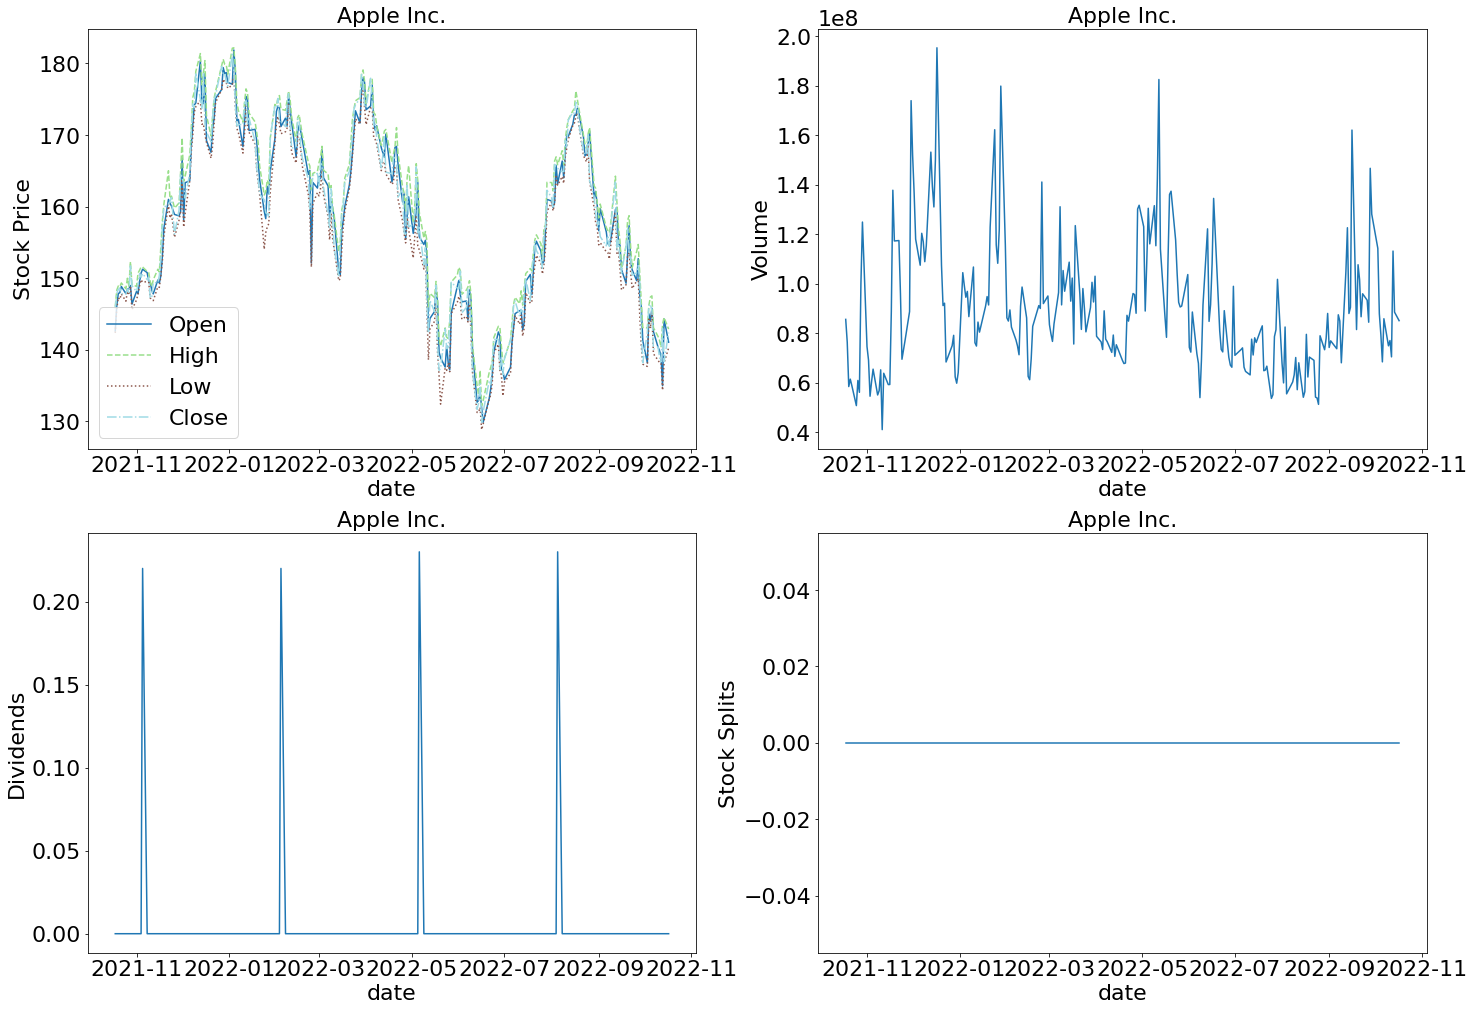

In [150]:
fig, ax = plt.subplots(2,2, figsize=(24,17))
colors_case = {"Open":colors[0], "High":colors[5], "Low":colors[10], "Close":colors[19]}
linestyle = {"Open":"-", "High":"--", "Low":":", "Close":"-."}

for case in ["Open", "High","Low", "Close"]:
    ax[0,0].plot(tickers.tickers["AAPL"].history(period="12mo")[case], color = colors_case[case], linestyle=linestyle[case], label=case)
ax[0,0].legend()
ax[0,1].plot(tickers.tickers["AAPL"].history(period="12mo")["Volume"], label=case)
ax[1,0].plot(tickers.tickers["AAPL"].history(period="12mo")["Dividends"], label=case)
ax[1,1].plot(tickers.tickers["AAPL"].history(period="12mo")["Stock Splits"], label=case)
names = [["Stock Price", "Volume"], ["Dividends", "Stock Splits"]]
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("date")
        ax[i,j].set_ylabel(names[i][j])
        ax[i,j].set_title("Apple Inc.")

## Expected return for the asset

$$\mu_{t} = \frac{P_{t} - P_{t-1}}{P_{t-1}}$$

where $P_{t}$ is the price of the stock at time $t$. This is a value that we should forecast, but we will use the prices for 2021-2022. 

In [151]:
# Price of all the stocks of this example
Pt = np.array([tickers.tickers[stock].history(period="12mo")["Close"] for stock in stocks])

In [152]:
mu = (Pt[:,1:] - Pt[:,:-1]) / Pt[:,:-1]

Text(0.5, 1.0, 'Apple Inc.')

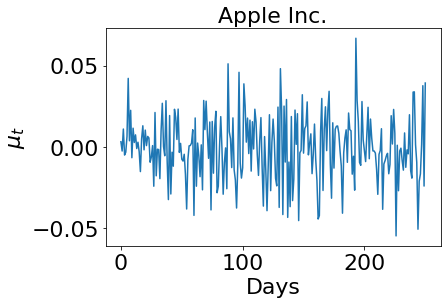

In [153]:
plt.figure()
plt.plot(mu[0])
plt.xlabel("Days")
plt.ylabel(r"$\mu_t$")
plt.title("Apple Inc.")

## Covariance

It is an indicator of how similar is the behaviour between two stocks!

$$\Sigma_{\mu_1,\mu_2} = \frac{\sum_t (\mu_{1,t} - \bar{\mu}_{1})(\mu_{2,t} - \bar{\mu}_{2})}{N-1}$$

where $\mu_{1,t}$ and $\mu_{2,t}$ are the expected return of assets 1 and 2 at time $t$, respectively, and $\bar{\mu}_{1,2}$ are they mean value.

In [154]:
N_stocks, N_days = mu.shape
sigma = np.zeros((N_stocks, N_stocks))
for i in range(N_stocks-1):
    for j in range(i, N_stocks):
        sigma[i,j] = ((mu[i] - mu[i].mean()) * (mu[j] - mu[j].mean())).sum()/(N_time - 1)
sigma += sigma.T
# sigma = np.cov(mu, varcol=True)

Text(0.5, 1.0, 'Covariance Matrix $\\Sigma$ associated to the risk')

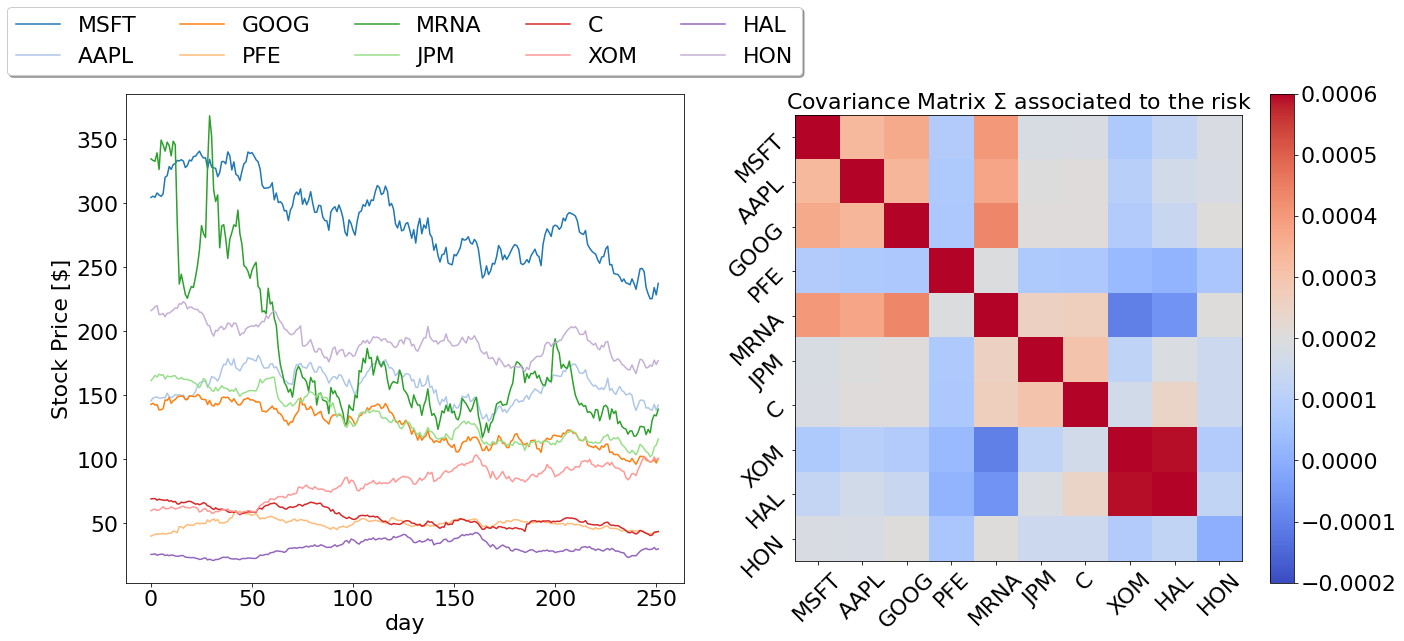

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(22,9))
for i in range(N_stocks):
    ax[0].plot(range(N_days+1), Pt[i], color=colors[i], label=stocks[i])
ax[0].set_xlabel("day")
ax[0].set_ylabel("Stock Price [$]")
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, fancybox=True, shadow=True)
im = ax[1].imshow(sigma, cmap="coolwarm", vmin=-0.0002, vmax=0.0006)
fig.colorbar(im)
ax[1].set_yticks(range(N_stocks))
ax[1].set_xticks(range(N_stocks))
ax[1].set_xticklabels(stocks, rotation=45)
ax[1].set_yticklabels(stocks, rotation=45)
ax[1].set_title(r"Covariance Matrix $\Sigma$ associated to the risk")

## Setting the other parameters in the objective function equation

In [169]:
q = 0.1 # Risk aversion
Budget = 7 # I can invest in 7 stocks
c = N_stocks * [1] # Minimum we can invest in the different assets c_i

## Solving the problem using DOCPLEX


#### Obtain the Quadratic problem from docplex

Once it is obtained the data for the portfolio optimization problem, the next step is to translate it into a docplex model. Considering the above data of expected returns, covariances, risk factor, and budget the docplex model to solve it is given by:

In [170]:
mdl = Model('Portfolio Optimization')

# Binary set of variables that represent the stocks
x = np.array(mdl.binary_var_list(N_stocks, name=stocks)) # x vector in numpy array for matrix multiplication

# Portfolio optimization function
objective_function = mu.mean(axis=1) @ x - q * x.T @ sigma @ x
mdl.maximize(objective_function)

# Budget constraint
mdl.add_constraint(c @ x == Budget, ctname='budget')

# Printing the docplex model
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: Portfolio Optimization
// var contrainer section
dvar bool x1[10];

maximize
 - 0.000787 MSFT + 0.000120 AAPL - 0.001152 GOOG + 0.000539 PFE
 - 0.002275 MRNA - 0.001154 JPM - 0.001635 C + 0.002315 XOM + 0.001105 HAL
 - 0.000680 HON [ - 0.000082 MSFT^2 - 0.000066 MSFT*AAPL - 0.000073 MSFT*GOOG
 - 0.000017 MSFT*PFE - 0.000081 MSFT*MRNA - 0.000037 MSFT*JPM
 - 0.000037 MSFT*C - 0.000016 MSFT*XOM - 0.000026 MSFT*HAL - 0.000037 MSFT*HON
 - 0.000085 AAPL^2 - 0.000067 AAPL*GOOG - 0.000015 AAPL*PFE
 - 0.000075 AAPL*MRNA - 0.000040 AAPL*JPM - 0.000041 AAPL*C
 - 0.000020 AAPL*XOM - 0.000034 AAPL*HAL - 0.000036 AAPL*HON - 0.000097 GOOG^2
 - 0.000015 GOOG*PFE - 0.000087 GOOG*MRNA - 0.000041 GOOG*JPM
 - 0.000041 GOOG*C - 0.000017 GOOG*XOM - 0.000028 GOOG*HAL - 0.000040 GOOG*HON
 - 0.000078 PFE^2 - 0.000039 PFE*MRNA - 0.000015 PFE*JPM - 0.000014 PFE*C
 - 0.000006 PFE*XOM - 0.000003 PFE*HAL - 0.000014 PFE*HON - 0.000489 MRNA^2
 - 0.000051 MR

In [172]:
sol_docplex = mdl.solve()
sol_docplex = {st: int(sol_docplex.get_value(st)) for st in stocks}
sol_docplex

{'MSFT': 1,
 'AAPL': 1,
 'GOOG': 0,
 'PFE': 1,
 'MRNA': 0,
 'JPM': 1,
 'C': 0,
 'XOM': 1,
 'HAL': 1,
 'HON': 1}

## Solving the QUBO of the Portfolio Optimization problem using QAOA

Using the library qiskit_optimization, we can translate the quadratic program (docplex representation of the problem) into the QUBO representation.


In [196]:
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.runtime import QAOAClient, VQEClient
from qiskit.algorithms import VQE, QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer  # local simulator
from qiskit.algorithms.optimizers import SPSA, COBYLA

backend = Aer.get_backend("qasm_simulator")
qubo = from_docplex_mp(mdl)

In [189]:
def optimization_QAOA(qubo, reps=1, optimizer=SPSA(maxiter=50), backend=None,
                      shots=1024, provider=None):
    intermediate_info = {'nfev': [],
                         'parameters': [],
                         'stddev': [],
                         'mean': []
                             }
    
    def callback(nfev, parameters, mean, stddev):
        intermediate_info['nfev'].append(nfev)
        intermediate_info['parameters'].append(parameters)
        intermediate_info['mean'].append(mean)
        intermediate_info['stddev'].append(stddev)
    
    qaoa_mes = QAOA(optimizer=optimizer, reps=reps, quantum_instance=backend,
                    callback=callback)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qubo)
    return result, intermediate_info

In [201]:
sol_spsa, info_spsa = optimization_QAOA(qubo, backend=backend)

In [198]:
sol_cobyla, info_cobyla = optimization_QAOA(qubo, backend=backend, optimizer=COBYLA())

In [206]:
solutions = {"Stocks":stocks_info["Stocks"], "CPLEX":sol_docplex.values(), "COBYLA":sol_cobyla.x, "SPSA":sol_spsa.x}
pd.DataFrame(solutions)

,Stocks,CPLEX,COBYLA,SPSA
0,MSFT,1,1.0,1.0
1,AAPL,1,1.0,1.0
2,GOOG,0,0.0,0.0
3,PFE,1,1.0,1.0
4,MRNA,0,0.0,0.0
5,JPM,1,1.0,1.0
6,C,0,0.0,0.0
7,XOM,1,1.0,1.0
8,HAL,1,1.0,1.0
9,HON,1,1.0,1.0


Text(0, 0.5, 'Cost func.')

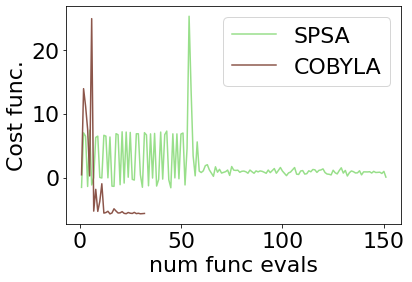

In [207]:
plt.figure()
plt.plot(info_spsa["nfev"], info_spsa["mean"], label="SPSA", color=colors[5])
plt.plot(info["nfev"], info["mean"], label = "COBYLA", color=colors[10])
plt.legend()
plt.xlabel("num func evals")
plt.ylabel("Cost func.")

## Homework: Can you improve the minimum found using QAOA using VQE?


In [209]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(N_stocks, rotation_blocks='ry', entanglement_blocks='cz')

In [ ]:
def Optimization_VQE(qubo, ansatz, optimizer=SPSA(maxiter=50), backend=None, shots=1024):

    intermediate_info = {'nfev': [],
                         'parameters': [],
                         'stddev': [],
                         'mean': []
                         }

    def callback(nfev, parameters, mean, stddev):
        intermediate_info['nfev'].append(nfev)
        intermediate_info['parameters'].append(parameters)
        intermediate_info['mean'].append(mean)
        intermediate_info['stddev'].append(stddev)
        
    vqe_mes = VQE(ansatz=ansatz, quantum_instance=backend, callback=callback, optimizer=optimizer)
    vqe = MinimumEigenOptimizer(vqe_mes)
    result = vqe.solve(qubo)
    return result, intermediate_info

In [210]:
import qiskit.tools.jupyter
%qiskit_version_table
